In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
df = pd.read_csv("amazon_reviews_features.txt", sep="\t")

# Preprocessing
# Combine REVIEW_TITLE and REVIEW_TEXT into a single column
df['REVIEW'] = df['REVIEW_TITLE'] + ' ' + df['REVIEW_TEXT']

# Function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove special characters and punctuation
    tokens = [re.sub(r'[^a-zA-Z0-9\s]', '', token) for token in tokens]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to REVIEW_TEXT column
df['REVIEW_TEXT'] = df['REVIEW_TEXT'].apply(preprocess_text)

# Feature extraction
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['REVIEW'])
tfidf_weights = tfidf_matrix.toarray()

# Select top 2000 n-grams based on their tf-idf scores
total_tfidf_scores = np.sum(tfidf_weights, axis=0)
top_indices = total_tfidf_scores.argsort()[-2000:][::-1]
top_ngrams = [tfidf_vectorizer.get_feature_names_out()[i] for i in top_indices]

# Dimensionality reduction for n-grams
X_ngrams_selected = SelectKBest(score_func=f_classif, k=2000).fit_transform(tfidf_weights, df['TARGET'])
X_ngrams_lsa = TruncatedSVD(n_components=1500, random_state=42).fit_transform(X_ngrams_selected)



# Word Embeddings
content_review_tokens = [text.split() for text in df['REVIEW']]
skipgram_model = Word2Vec(sentences=content_review_tokens, vector_size=100, window=5, min_count=1, sg=1)

# Average Word Embedding
avg_embedding_reviews = []
for tokens in content_review_tokens:
    embeddings = [skipgram_model.wv[word] for word in tokens if word in skipgram_model.wv]
    avg_embedding = np.mean(embeddings, axis=0) if embeddings else np.zeros(100)
    avg_embedding_reviews.append(avg_embedding)

# Emotion Features
emotion_X = df[['VERIFIED_PURCHASE', 'OPI_FIN_POS', 'OPI_FIN_NEG', 'BL_POS', 'BL_NEG', 'AFINN_POS',
                'AFINN_NEG', 'S140_POS', 'S140_NEG', 'SWN_POS', 'SWN_NEG',
                'NRC_HASH_POS', 'NRC_HASH_NEG', 'EMOTICON_POS', 'EMOTICON_NEG',
                'NRC_ANGER', 'NRC_ANTICIPATION', 'NRC_DISGUST', 'NRC_FEAR', 'NRC_JOY',
                'NRC_SADNESS', 'NRC_SURPRISE', 'NRC_TRUST', 'NRC_EXP_ANGER',
                'NRC_EXP_ANTICIPATION', 'NRC_EXP_DISGUST', 'NRC_EXP_FEAR',
                'NRC_EXP_JOY', 'NRC_EXP_SADNESS', 'NRC_EXP_SURPRISE', 'NRC_EXP_TRUST']].values.tolist()

# Combine features
X = np.concatenate((X_ngrams_lsa, avg_embedding_reviews, emotion_X), axis=1)

# Train-test split
# X_train = np.concatenate((X[:8400], X[10500:18900]))
# X_test = np.concatenate((X[8400:10500], X[18900:]))
# y_train = np.concatenate((df['TARGET'].values[:8400], df['TARGET'].values[10500:18900]))
# y_test = np.concatenate((df['TARGET'].values[8400:10500], df['TARGET'].values[18900:]))

X_train, X_test, y_train, y_test = train_test_split(X, df['TARGET'].values, test_size=0.23, random_state=42)


# Define the DFFNN model
model = Sequential()
model.add(Dense(200, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

/Users/malayshikhar/anaconda3/envs/TDL/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5194 - loss: 0.7871 - val_accuracy: 0.6983 - val_loss: 0.6479
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6688 - loss: 0.6174 - val_accuracy: 0.7783 - val_loss: 0.4995
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7870 - loss: 0.5025 - val_accuracy: 0.7967 - val_loss: 0.4773
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8012 - loss: 0.4805 - val_accuracy: 0.8029 - val_loss: 0.4592
Epoch 5/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8022 - loss: 0.4613 - val_accuracy: 0.8070 - val_loss: 0.4556
Epoch 6/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8116 - loss: 0.4524 - val_accuracy: 0.8025 - val_loss: 0.4459
Epoch 7/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8164 - loss: 0.4313 - val_accuracy: 0.7979 - val_loss: 0.4531
Epoch 8/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8228 - loss: 0.4243 - val_accuracy: 0.

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
Accuracy: 0.8128364389233954
Precision: 0.7892675283979632
Recall: 0.8462830743385132
F1 Score: 0.8167815160113497
AUC Score: 0.8133007858421843


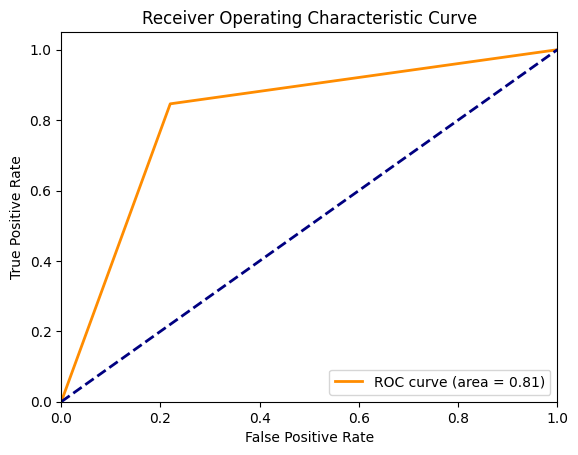

Confusion Matrix:
[[1911  538]
 [ 366 2015]]


In [3]:
# Predict probabilities on test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Flatten predictions
y_pred = y_pred.flatten()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC Score: {roc_auc}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
